<a href="https://colab.research.google.com/github/CPernet/OpenNeuro_MetaPrivAssessment/blob/main/BTC_ds002080.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Libraries

In [ ]:
# Import Libraries
!git clone https://github.com/CPernet/OpenNeuro_MetaPrivAssessment.git

import sys
sys.path.append("..")
import os
os.chdir('OpenNeuro_MetaPrivAssessment') # Change directory to the cloned repository

Cloning into 'OpenNeuro_MetaPrivAssessment'...
remote: Enumerating objects: 96, done.
remote: Counting objects: 100% (96/96), done.
remote: Compressing objects: 100% (88/88), done.
remote: Total 96 (delta 21), reused 69 (delta 6), pack-reused 0 (from 0)
Receiving objects: 100% (96/96), 1.30 MiB | 1.38 MiB/s, done.
Resolving deltas: 100% (21/21), done.


In [ ]:
%%bash
set -e
sudo apt-get update -qq
sudo DEBIAN_FRONTEND=noninteractive \
     apt-get install -qq -y --no-install-recommends r-base r-base-dev

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


In [ ]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import spearmanr
import warnings
!pip install piflib
!pip install -q rpy2
import metaprivBIDS_stat as ST
from metaprivBIDS_stat import plot_calc
from metaprivBIDS_stat import rst_outlier_case2


(as ‘lib’ is unspecified)











































	‘/tmp/Rtmp2H89ji/downloaded_packages’



## File from OpenNeuro Import
BTC is the raw dataset "Brain Tumor Connectomics Data" taken from OpenNeuro.


In [ ]:
BTC = 'https://s3.amazonaws.com/openneuro.org/ds002080/participants.tsv?versionId=LK7PRmZBsdzjwgZPqBKSdCjXdfxw4ory'
BTC = pd.read_csv(BTC, sep='\t')
BTC.to_csv('BrainTumorConnectomicsData/data_ds002080/btc_dataset_ds002080.csv', sep=',', index=False)

## Load in of results calculated using (MetaprivBIDS App)

The selected quasi identifers are:
- Education level (1-9)
- age
- height (cm)(pre-op)
- handedness
- Marital status
- Employment
- Sex


The dis-score fraction is the default 0.3 & missing values are indicated as NaN.

In [ ]:
suda = pd.read_csv('BrainTumorConnectomicsData/data_ds002080/suda_ds002080.csv', sep=',')
pif = pd.read_csv('BrainTumorConnectomicsData/data_ds002080/pif_ds002080.csv', sep=',',index_col='Unnamed: 0').sort_index()
suda_field_score =  pd.read_csv('BrainTumorConnectomicsData/data_ds002080/att_suda.csv', sep=',').drop(columns=['Unnamed: 0'], errors='ignore')
k_combined_field =  pd.read_csv('BrainTumorConnectomicsData/data_ds002080/normalized_difference_results.csv', sep=',').drop(columns=['Difference in Unique Rows','Unique Rows After Removal']).rename(columns={'Column': 'variable'})
k_combined_all = pd.read_csv('BrainTumorConnectomicsData/data_ds002080/k-combined-3-7.csv', sep=',')
k_combined_field_non_risk = pd.read_csv('BrainTumorConnectomicsData/data_ds002080/non_normalized_difference_results.csv', sep=',').drop(columns=['Difference in Unique Rows','Unique Rows After Removal']).rename(columns={'Column': 'variable'})

## Calculating Pearson and Spearman correlation on row level.


In [ ]:
suda['dis-score_rank'] = suda['score'].rank()
pif['RIG_rank'] = pif['RIG'].rank()
spearman_corr, p_value = spearmanr(pif['RIG_rank'], suda['dis-score_rank'])

print(spearman_corr, p_value)

0.8045724968569877 1.4394685371600376e-07


## Calculating Spearman correlation on field level.

In [ ]:
merged_df = pd.merge(suda_field_score, k_combined_field, on='variable', how='inner')
merged_df['k_rank'] = merged_df['Normalized Difference'].rank()
merged_df['suda_rank'] = merged_df['contribution'].rank()
spearman_corr, p_value = spearmanr(merged_df['k_rank'], merged_df['suda_rank'])
print(spearman_corr, p_value)


0.5790660241435863 0.17310584624513142


In [ ]:
columns_to_sum = pif.columns[(pif.columns != 'RIG') & (pif.columns != 'RIG_rank')]
column_sums = pif[columns_to_sum].sum()
new_df = column_sums.reset_index()
new_df.columns = ['variable', 'Sum']
merged_df_new = pd.merge(merged_df, new_df, on='variable', how='inner')
merged_df_new['pif_rank'] = merged_df_new['Sum'].rank()
spearman_corr, p_value = spearmanr(merged_df_new['k_rank'], merged_df_new['pif_rank'])
print(spearman_corr, p_value)

0.5790660241435863 0.17310584624513142


In [ ]:
merged_df_new

,variable,contribution,Normalized Difference,k_rank,suda_rank,Sum,pif_rank
0,age,46.96,0.1,6.0,7.0,124.126561,7.0
1,height (cm)(pre-op),41.12,0.0,3.0,6.0,114.516921,6.0
2,handedness,4.36,0.0,3.0,2.0,30.842349,3.0
3,Marital status,9.04,0.0,3.0,3.0,26.842349,1.0
4,Employment,12.22,0.0,3.0,4.0,51.968839,4.0
5,Education level (1-9),16.73,0.4,7.0,5.0,57.524732,5.0
6,sex,3.94,0.0,3.0,1.0,28.775733,2.0


## Iterating through all possible combination of variables & calculating the correlation between SUDA, K-Global and PIF

In [ ]:
sum_score_df  = ST.calculate_summed_dis_scores(k_combined_all, BTC, sample_fraction=0.3, missing_value= np.nan)

Spearman Correlation between Suda sum and K-combined: 0.75
Pearson Correlation between Suda sum and K-combined: 0.72


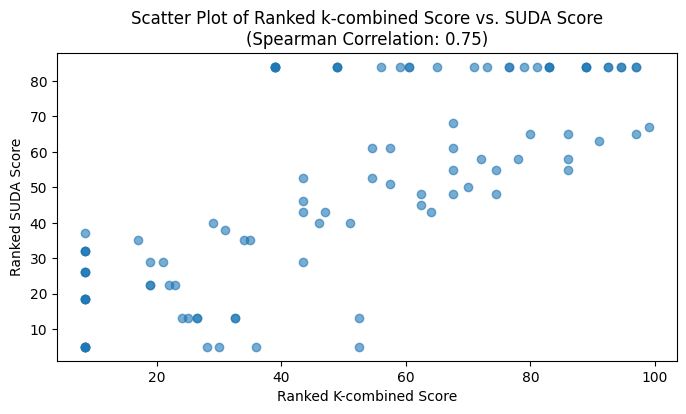

________________________________________________________________________


Spearman Correlation between PIF 95% and K-combined: 0.86
Pearson Correlation between PIF 95% and K-combined: 0.90


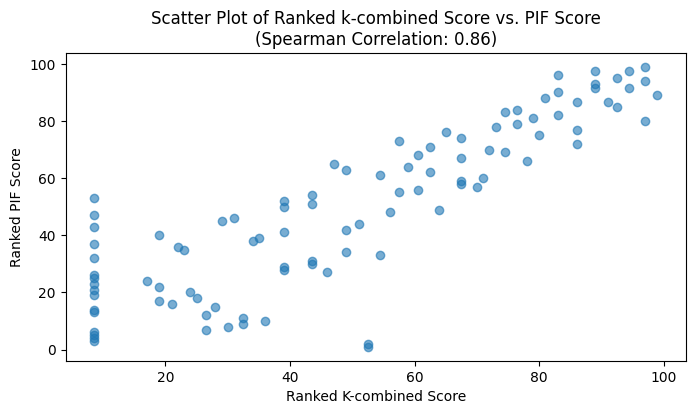

________________________________________________________________________


Spearman Correlation between PIF 95% and SUDA: 0.81
Pearson Correlation between PIF 95% and SUDA: 0.79


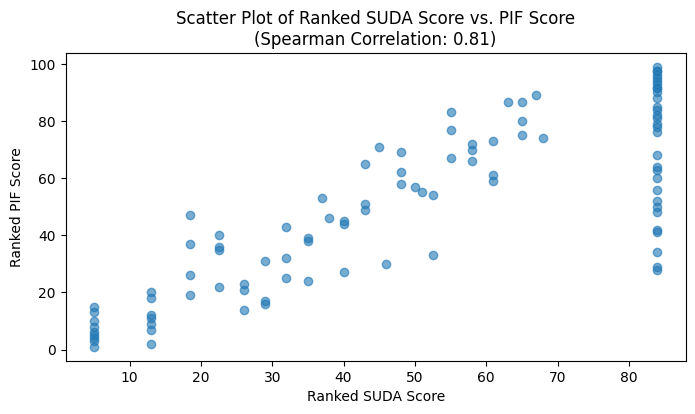

In [ ]:
plot_calc(sum_score_df)

# T-test between risky and non-risky k-global values for variables.


### Non risk variables


In [ ]:
k_combined_field_non_risk

,variable,Normalized Difference
0,ERQ reappraisal,0.0
1,MOT_latency_mean,0.0
2,MOT_error_mean,0.0
3,RTI_simpleRT_sd,0.0
4,RTI_simpleMT_mean,0.0
5,RTI_simpleMT_sd,0.0
6,RTI_fiveMT,0.0
7,RTI_fiveRT,0.0
8,RTI_fiveRT_sd,0.0
9,RTI_fiveMT_mean,0.0


### Risk Variables

In [ ]:
k_combined_field

,variable,Normalized Difference
0,Education level (1-9),0.4
1,age,0.1
2,height (cm)(pre-op),0.0
3,handedness,0.0
4,Marital status,0.0
5,Employment,0.0
6,sex,0.0


## Result of Paired T-test


In [ ]:
mean_risk_values = (k_combined_field['Normalized Difference']).mean()
print('Mean, risk identifiers:',mean_risk_values)
mean_risk_values = (k_combined_field_non_risk['Normalized Difference']).mean()
print('Mean, non-risk identifiers:',mean_risk_values)

Mean, risk identifiers: 0.07142857142857142
Mean, non-risk identifiers: 0.0


In [ ]:
t, p = stats.ttest_ind(k_combined_field['Normalized Difference'], k_combined_field_non_risk['Normalized Difference'])
print('t:',t,'p-value:', p)

t: 3.353091214466485 p-value: 0.001547703229896185


### PIF & SUDA Outliers

/content/OpenNeuro_MetaPrivAssessment/metaprivBIDS_stat.py:229: RuntimeWarning: invalid value encountered in divide
  z_scores = (column_data_array - median) / madn


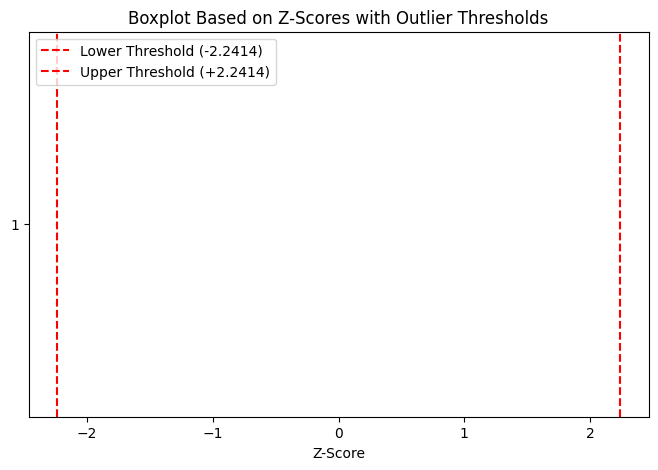

number of outliers 0


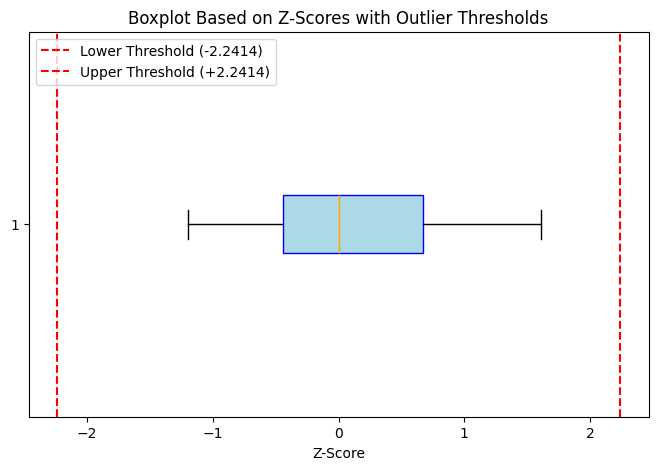

number of outliers 0


In [ ]:
results = ST.rst_outlier_case2(suda, 'dis-score')
class_outliers, madn, mad, outlier_indices = results[:4]
if len(results) > 4:
    above_outlier_indices = results[4]
else:
    above_outlier_indices = []  # Assign an empty list if not returned.
print('number of outliers',len(above_outlier_indices))

results = ST.rst_outlier_case2(pif, 'RIG')
class_outliers, madn, mad, outlier_indices = results[:4]
if len(results) > 4:
    above_outlier_indices = results[4]
else:
    above_outlier_indices = []  # Assign an empty list if not returned.
print('number of outliers',len(above_outlier_indices))